# Backtest Forecast Models

Train-test splits and k-fold cross-validation, do not work in the case of time series data. This is because they **ignore the temporal components inherent in the problem**. 
This is because they assume that there is no relationship between the observations, that each observation is independent. This is not true of time series data, where the time dimension of observations means that we cannot randomly split them into groups. 
Instead, we must split data up and respect the temporal order in which values were observed.

When evaluating a model for time series forecasting, we are interested in the performance of the model on data that was not used to train it. 
In machine learning, we call this unseen or out-of-sample data. We can do this by splitting up the data that we do have available. We use some to prepare the model and we hold back some data and ask the model to make predictions for that period. The evaluation of these predictions will provide a good proxy for how the model will perform when we use it operationally.

In time series forecasting, this evaluation of models on historical data is called backtesting.In time series forecasting, this evaluation of models on historical data is called backtesting.

We will look at three different methods that you can use to backtest your machine learning models on time series problems. They are:
1. Train-Test split that respect temporal order of observations.
2. Multiple Train-Test splits that respect temporal order of observations.
3. Walk-Forward Validation where a model may be updated each time step new data is received.

### Train-Test Split
Depending on the amount of data you have available and the amount of data required, you can use splits of 50-50, 70-30 and 90-10.Depending on the amount of data you have available and the amount of data required, you can use splits of 50-50, 70-30 and 90-10.

Observations: 2820
Training Observations: 1861
Testing Observations: 959


/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_8343/4091213208.py:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./data/sunspots.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


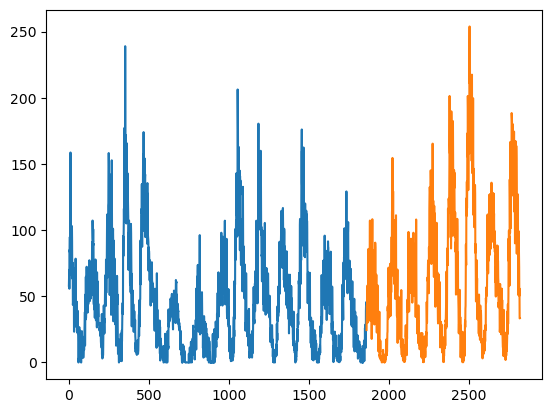

In [2]:
# plot train-test split of time series data
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('./data/sunspots.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = series.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
pyplot.plot(train)
pyplot.plot([None for i in train] + [x for x in test])
pyplot.show()

### Multiple Train-Test Splits
We can repeat the process of splitting the time series into train and test sets multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data. 
We could do this manually by repeating the process described in the previous section with different split points.

Alternately, the scikit-learn library provides this capability for us in the TimeSeriesSplit object. You must specify the number of splits to create and the TimeSeriesSplit to return the indexes of the train and test observations for each requested split. The total number of training and test observations are calculated each split iteration (i) as follows:

![](./data/Screen%20Shot%202022-10-22%20at%2019.05.18.png)

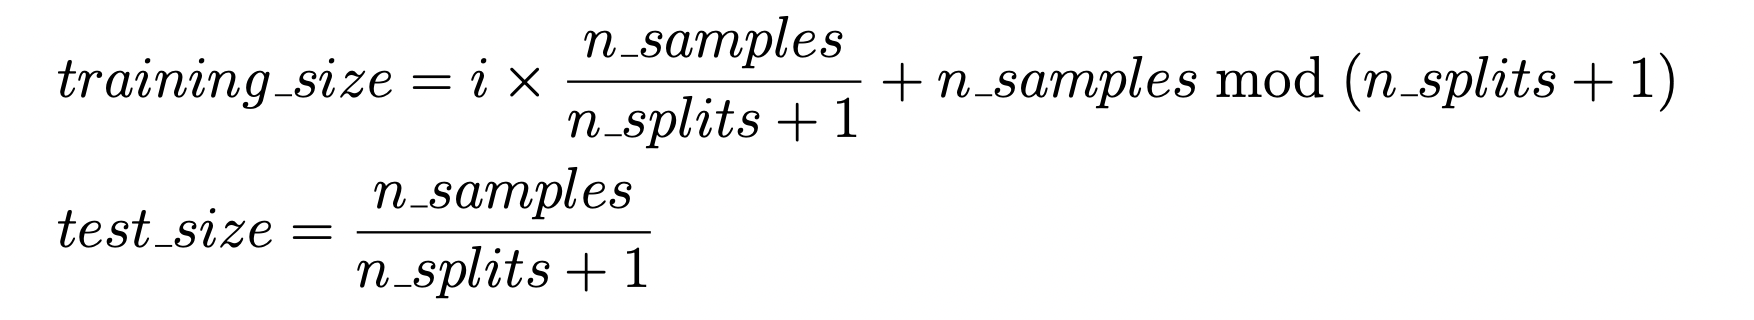

In [3]:
from IPython.display import Image
Image(filename='./data/Screen Shot 2022-10-22 at 19.05.18.png') 


/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_8343/3594475671.py:5: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./data/sunspots.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


Observations: 1410
Training Observations: 705
Testing Observations: 705
Observations: 2115
Training Observations: 1410
Testing Observations: 705
Observations: 2820
Training Observations: 2115
Testing Observations: 705


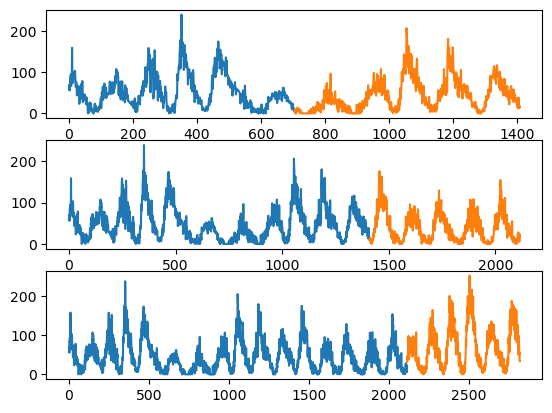

In [4]:
# calculate repeated train-test splits of time series data
from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot
series = read_csv('./data/sunspots.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = series.values
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
	train = X[train_index]
	test = X[test_index]
	print('Observations: %d' % (len(train) + len(test)))
	print('Training Observations: %d' % (len(train)))
	print('Testing Observations: %d' % (len(test)))
	pyplot.subplot(310 + index)
	pyplot.plot(train)
	pyplot.plot([None for i in train] + [x for x in test])
	index += 1
pyplot.show()

What differs is the number of records used to train the model each split, offering a larger and larger history to work with. This may make an interesting aspect of the analysis of results. Alternately, this too could be controlled by holding the number of observations used to train the model consistent and only using the same number of the most recent (last) observations in the training dataset each split to train the model, 33 in this contrived example.

Using multiple train-test splits will result in more models being trained, and in turn, a more accurate estimate of the performance of the models on unseen data.
A limitation of the train-test split approach is that the trained models remain fixed as they are evaluated on each evaluation in the test set.
This may not be realistic as models can be retrained as new daily or monthly observations are made available.

### Walk Forward Validation

In practice, we very likely will retrain our model as new data becomes available. This would give the model the best opportunity to make good forecasts at each time step. We can evaluate our machine learning models under this assumption. 

1. Minimum Number of Observations. First, we must select the minimum number of observations required to train the model. This may be thought of as the window width if a sliding window is used (see next point).

2. Sliding or Expanding Window. Next, we need to decide whether the model will be trained on all data it has available or only on the most recent observations. This determines whether a sliding or expanding window will be used.


After a sensible configuration is chosen for your test-setup, models can be trained and evaluated.
1. Starting at the beginning of the time series, the minimum number of samples in the window is used to train a model.
2. The model makes a prediction for the next time step.
3. The prediction is stored or evaluated against the known value.
4. The window is expanded to include the known value and the process is repeated (go to step 1.)

Because this methodology involves moving along the time series one-time step at a time, it is often called **Walk Forward Testing** or **Walk Forward Validation**. 

Additionally, because a sliding or expanding window is used to train a model, this method is also referred to as Rolling Window Analysis or a Rolling Forecast. 
This capability is currently not available in scikit-learn, although you could contrive the same effect with a carefully configured TimeSeriesSplit.

In [5]:
# walk forward evaluation model for time series data
from pandas import read_csv
series = read_csv('./data/sunspots.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = series.values
n_train = 500
n_records = len(X)
for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print('train=%d, test=%d' % (len(train), len(test)))

train=500, test=1
train=501, test=1
train=502, test=1
train=503, test=1
train=504, test=1
train=505, test=1
train=506, test=1
train=507, test=1
train=508, test=1
train=509, test=1
train=510, test=1
train=511, test=1
train=512, test=1
train=513, test=1
train=514, test=1
train=515, test=1
train=516, test=1
train=517, test=1
train=518, test=1
train=519, test=1
train=520, test=1
train=521, test=1
train=522, test=1
train=523, test=1
train=524, test=1
train=525, test=1
train=526, test=1
train=527, test=1
train=528, test=1
train=529, test=1
train=530, test=1
train=531, test=1
train=532, test=1
train=533, test=1
train=534, test=1
train=535, test=1
train=536, test=1
train=537, test=1
train=538, test=1
train=539, test=1
train=540, test=1
train=541, test=1
train=542, test=1
train=543, test=1
train=544, test=1
train=545, test=1
train=546, test=1
train=547, test=1
train=548, test=1
train=549, test=1
train=550, test=1
train=551, test=1
train=552, test=1
train=553, test=1
train=554, test=1
train=555,

/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_8343/1510125926.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./data/sunspots.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


You can see that many more models are created. This has the benefit again of providing a much more robust estimation of how the chosen modeling method and parameters will perform in practice. This improved estimate comes at the computational cost of creating so many models. This is not expensive if the modeling method is simple or dataset is small (as in this example), but could be an issue at scale. In the above case, 2,820 models would be created and evaluated.


As such, careful attention needs to be paid to the window width and window type. These could be adjusted to contrive a test harness on your problem that is significantly less computationally expensive. Walk-forward validation is the gold standard of model evaluation. It is the k-fold cross-validation of the time series world and is recommended for your own projects.

# Forecasting Performance Measures

## Forecast Error (or Residual Forecast Error)
The forecast error is calculated as the expected value minus the predicted value. This is called the residual error of the prediction.
$$forecast\textrm{_}error = expected\textrm{_}value − predicted\textrm{_}value$$
The forecast error can be calculated for each prediction, providing a time series of forecast errors. like accuracy in Classification.

In [6]:
# calculate forecast error
expected = [0.0, 0.5, 0.0, 0.5, 0.0]
predictions = [0.2, 0.4, 0.1, 0.6, 0.2]
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
print('Forecast Errors: %s' % forecast_errors)

Forecast Errors: [-0.2, 0.09999999999999998, -0.1, -0.09999999999999998, -0.2]


## Mean Forecast Error (or Forecast Bias)
Mean forecast error is calculated as the average of the forecast error values.
$$mean\textrm{_}forecast\textrm{_}error = mean(forecast\textrm{_}error)$$
Forecast errors can be positive and negative. This means that when the average of these values is calculated, an ideal mean forecast error would be zero. A mean forecast error value other than zero suggests a tendency of the model to over forecast (negative error) or under forecast (positive error). As such, the mean forecast error is also called the forecast bias. The forecast error can be calculated directly as the mean of the forecast values.

## Mean Absolute Error
The mean absolute error, or MAE, is calculated as the average of the forecast error values, where all of the forecast values are forced to be positive. Forcing values to be positive is called making them absolute. This is signified by the absolute function $abs()$ or shown mathematically as two pipe characters around the value: $|value|$.
$$mean\textrm{_}absolute\textrm{_}error = mean(abs(forecast\textrm{_}error))$$

In [7]:
# calculate mean absolute error
from sklearn.metrics import mean_absolute_error
expected = [0.0, 0.5, 0.0, 0.5, 0.0]
predictions = [0.2, 0.4, 0.1, 0.6, 0.2]
mae = mean_absolute_error(expected, predictions)
print('MAE: %f' % mae)

MAE: 0.140000


## Mean Squared Error
The mean squared error, or MSE, is calculated as the average of the squared forecast error values. Squaring the forecast error values forces them to be positive; it also has the effect of putting more weight on large errors. Very large or outlier forecast errors are squared, which in turn has the effect of dragging the mean of the squared forecast errors out resulting in a larger mean squared error score. In effect, the score gives worse performance to those models that make large wrong forecasts.
$$mean\textrm{_}squared\textrm{_}error = mean(forecast\textrm{_}error^2)$$

In [8]:
# calculate mean squared error
from sklearn.metrics import mean_squared_error
expected = [0.0, 0.5, 0.0, 0.5, 0.0]
predictions = [0.2, 0.4, 0.1, 0.6, 0.2]
mse = mean_squared_error(expected, predictions)
print('MSE: %f' % mse)

MSE: 0.022000


## Root Mean Squared Error
The mean squared error described above is in the squared units of the predictions. It can be transformed back into the original units of the predictions by taking the square root of the mean squared error score. This is called the root mean squared error, or RMSE.
$$rmse = \sqrt{mean\textrm{_}squared\textrm{_}error}$$

In [9]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
expected = [0.0, 0.5, 0.0, 0.5, 0.0]
predictions = [0.2, 0.4, 0.1, 0.6, 0.2]
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.148324


# Persistence Model for Forecasting

Establishing a baseline is essential on any time series forecasting problem. A baseline in performance gives you an idea of how well all other models will actually perform on your problem.

A baseline in forecast performance provides a point of comparison. It is a point of reference for all other modeling techniques on your problem. If a model achieves performance at or below the baseline, the technique should be fixed or abandoned. The technique used to generate a forecast to calculate the baseline performance must be easy to implement and naive of problem-specific details. Before you can establish a performance baseline on your forecast problem, you must develop a test harness. This is comprised of:
1. The dataset you intend to use to train and evaluate models.
2. The resampling technique you intend to use to estimate the performance of the technique (e.g. train/test split).
3. The performance measure you intend to use to evaluate forecasts (e.g. root mean squared error).

Once prepared, you then need to select a naive technique that you can use to make a forecast and calculate the baseline performance. The goal is to get a baseline performance on your time series forecast problem as quickly as possible so that you can get to work better understanding the dataset and developing more advanced models. Three properties of a good technique for making a baseline forecast are:

- **Simple:** A method that requires little or no training or intelligence.
- **Fast:** A method that is fast to implement and computationally trivial to make a prediction.
- **Repeatable:** A method that is deterministic, meaning that it produces an expected output given the same input.

### Persistence Algorithm
The most common baseline method for supervised machine learning is the **Zero Rule algorithm**. This algorithm predicts the majority class in the case of classification, or the average outcome in the case of regression. This could be used for time series, but does not respect the serial correlation structure in time series datasets. The equivalent technique for use with time series dataset is the persistence algorithm.

The persistence algorithm uses the value at the current time step (t) to predict the expected outcome at the next time step (t+1). This satisfies the three above conditions for a baseline forecast. To make this concrete, we will look at how to develop a persistence model and use it to establish a baseline performance for a simple univariate time series problem. First, let’s review the Shampoo Sales dataset.

### Persistence Algorithm Steps
A persistence model can be implemented easily in Python. We will break this tutorial down into 4 steps:
1. Transform the univariate dataset into a supervised learning problem. 
2. Establish the train and test datasets for the test harness.
3. Define the persistence model.
4. Make a forecast and establish a baseline performance.
5. Review the complete example and plot the output.

       t    t+1
0    NaN  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3
Test RMSE: 133.156


/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_8343/714625103.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_8343/714625103.py:12: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./data/shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)


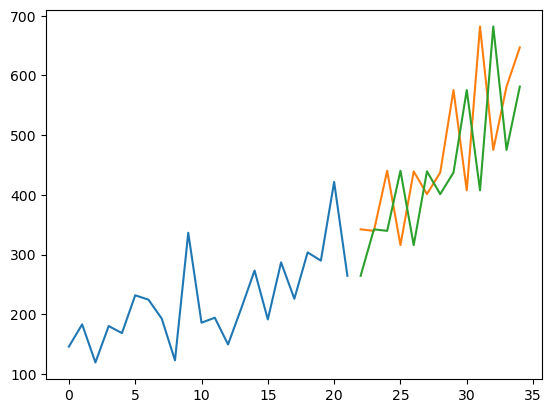

In [11]:
# evaluate a persistence forecast model
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('./data/shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
def model_persistence(x):
	return x
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# plot predictions and expected results
pyplot.plot(train_y)
pyplot.plot([None for i in train_y] + [x for x in test_y])
pyplot.plot([None for i in train_y] + [x for x in predictions])
pyplot.show()

# Visualize Residual Forecast Errors

Forecast errors on time series regression problems are called residuals or residual errors. Careful exploration of residual errors on your time series prediction problem can tell you a lot about your forecast model and even suggest improvements.

Forecast errors on a time series forecasting problem are called residual errors or residuals. A residual error is calculated as the expected outcome minus the forecast, for example:
$$residual\textrm{_}error = expected − forecast$$

### Residual Line Plot
The first plot is to look at the residual forecast errors over time as a line plot. We would expect the plot to be random around the value of 0 and not show any trend or cyclic structure. The array of residual errors can be wrapped in a Pandas DataFrame and plotted directly.

      0
0   9.0
1 -10.0
2   3.0
3  -6.0
4  30.0


/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_8343/3745400736.py:5: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./data/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


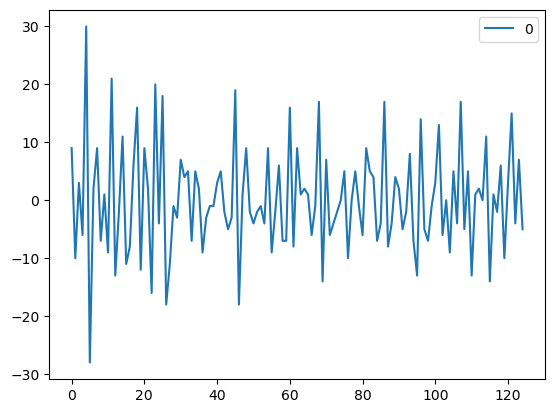

In [16]:
# calculate residuals from a persistence forecast
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
series = read_csv('./data/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
predictions = [x for x in test_X]
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = DataFrame(residuals)
print(residuals.head())
# plot residuals
residuals.plot()
pyplot.show()


### Residual Summary Statistics
We can calculate summary statistics on the residual errors. Primarily, we are interested in the mean value of the residual errors. A value close to zero suggests no bias in the forecasts, whereas positive and negative values suggest a positive or negative bias in the forecasts made. It is useful to know about a bias in the forecasts as it can be directly corrected in forecasts prior to their use or evaluation.


In [18]:
# summary statistics of residual errors
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
series = read_csv('./data/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
predictions = [x for x in test_X]
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = DataFrame(residuals)
# summary statistics
print(residuals.describe())

                0
count  125.000000
mean     0.064000
std      9.187776
min    -28.000000
25%     -6.000000
50%     -1.000000
75%      5.000000
max     30.000000


/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_8343/2475065137.py:5: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./data/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


### Residual Histogram and Density Plots
Plots can be used to better understand the distribution of errors beyond summary statistics. We would expect the forecast errors to be normally distributed around a zero mean. Plots can help discover skews in this distribution. We can use both histograms and density plots to better understand the distribution of residual errors.

/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_8343/1177747032.py:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./data/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


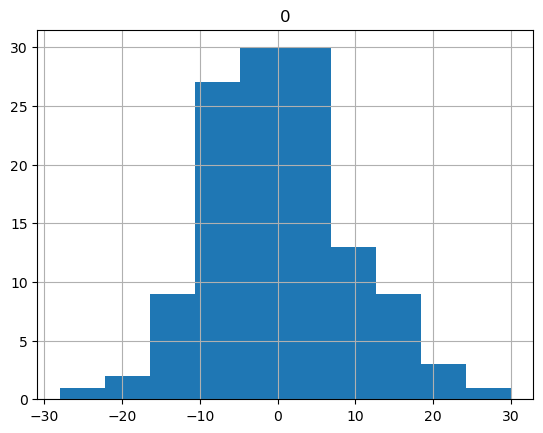

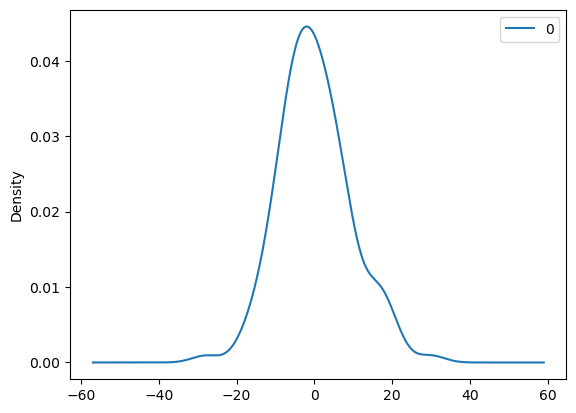

In [20]:
# density plots of residual errors
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
series = read_csv('./data/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
predictions = [x for x in test_X]
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = DataFrame(residuals)
# histogram plot
residuals.hist()
pyplot.show()
# density plot
residuals.plot(kind='kde')
pyplot.show()

### Residual Q-Q Plot

A Q-Q plot, or quantile plot, compares two distributions and can be used to see how similar or different they happen to be. We can create a Q-Q plot using the qqplot() function1 in the Statsmodels library.

The Q-Q plot can be used to quickly check the normality of the distribution of residual errors. The values are ordered and compared to an idealized Gaussian distribution. The comparison is shown as a scatter plot (theoretical on the x-axis and observed on the y-axis) where a match between the two distributions is shown as a diagonal line from the bottom left to the top-right of the plot.

The plot is helpful to spot obvious departures from this expectation. Below is an example of a Q-Q plot of the residual errors. The x-axis shows the theoretical quantiles and the y-axis shows the sample quantiles.


/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_8343/4132027574.py:8: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./data/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


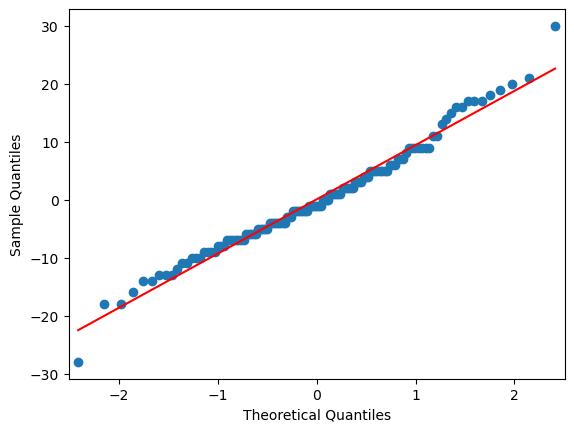

In [21]:
# qq plot of residual errors
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
import numpy
from statsmodels.graphics.gofplots import qqplot
series = read_csv('./data/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
predictions = [x for x in test_X]
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = numpy.array(residuals)
qqplot(residuals, line='r')
pyplot.show()

### Residual Autocorrelation Plot
Autocorrelation calculates the strength of the relationship between an observation and observations at prior time steps. 
We can calculate the autocorrelation of the residual error time series and plot the results. This is called an autocorrelation plot. We would not expect there to be any correlation between the residuals. 
This would be shown by autocorrelation scores being below the threshold of significance (dashed and dotted horizontal lines on the plot).

A significant autocorrelation in the residual plot suggests that the model could be doing a better job of incorporating the relationship between observations and lagged observations, called autoregression. Pandas provides a built-in function for calculating an autocorrelation plot, called autocorrelation plot().

/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_8343/4188338868.py:7: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./data/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


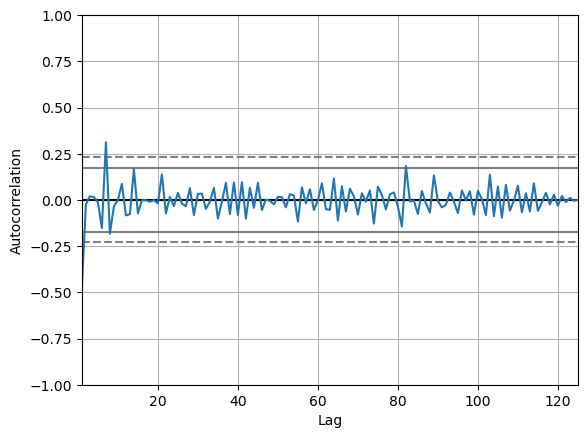

In [22]:
# autoregression plot of residual errors
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
series = read_csv('./data/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
predictions = [x for x in test_X]
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = DataFrame(residuals)
autocorrelation_plot(residuals)
pyplot.show()

Running the example creates an autoregression plot of other residual errors. We do not see an obvious autocorrelation trend across the plot. There may be some positive autocorrelation worthy of further investigation at lag 7 that seems significant.

# Reframe Time Series Forecasting Problems

There are many ways to reframe your forecast problem that can both simplify the prediction problem and potentially expose more or different information to be modeled. A reframing can ultimately result in better and/or more robust forecasts.

### Benefits of Reframing Your Problem
Reframing your problem is the idea of exploring alternate perspectives on what is to be predicted. There are two potential benefits to exploring alternate framings of your time series forecast problem:
1. Simplify your problem.
2. Provide the basis for an ensemble forecast.
Both benefits ultimately have the result of leading to more skillful and/or more robust forecasts.

### Simplify your problem
erhaps the largest wins on a forecasting project can come from a reframing of the problem. This is because the structure and type of prediction problem has so much more impact than the choice of data transforms, choice of model, or the choice of model hyperparameters. It is the biggest lever in a project and must be carefully considered.

### Ensemble Forecast
In addition to changing the problem you are working on, reframing plays another role: it can provide you with a suite of different, but highly related problems that you can model. The benefit of this is that the framings may be different enough to require differences in data preparation and modeling methods.
Models of differing perspectives on the same problem may capture different information from the input and in turn result in predictions that are skillful, but in different ways. These predictions may be combined in an ensemble to result in a more skillful or more robust forecast. 

### Regression Framings
Most time series prediction problems are regression problems, requiring the prediction of a real-valued output. Below are 5 different ways that this prediction problem could be re-phrased as an alternate regression problem:
- Forecast the change in the minimum temperature compared to the previous day.
- Forecast the minimum temperature relative to the average from the past 14 days.
- Forecast the minimum temperature relative to the average the same month last year.
- Forecast the minimum temperature rounded to the nearest 5 degrees Celsius.
- Forecast the average minimum temperature for the next 7 days.

Making the temperature relative is a linear transform and may not make the problem simpler and easier to predict, but it may shake loose new ideas or even new sources of data that you may consider. It also may help you think more clearly about how exactly the forecast will be used and what the hard requirements on that forecasted value actually are.

In [23]:
# reframe precision of regression forecast
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
# load data
series = read_csv('./data/daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# round forecast to nearest 5
for i in range(len(dataframe['t+1'])):
	dataframe['t+1'][i] = int(dataframe['t+1'][i] / 5) * 5.0
print(dataframe.head(5))

/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_8343/427567478.py:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./data/daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


      t   t+1
0   NaN  20.0
1  20.7  15.0
2  17.9  15.0
3  18.8  10.0
4  14.6  15.0


### Classification Framings
Classification involves predicting categorical or label outputs (like hot and cold). Below are 5 different ways that this prediction problem can be rephrased as a classification problem:
- Forecast whether a minimum temperature will be cold, moderate, or warm. 
- Forecast whether a change in minimum temperature will be small or large.
- Forecast whether the minimum temperature will be a monthly minimum or not.
- Forecast whether the minimum will be higher or lower than the minimum in the previous year.
- Forecast whether the minimum temperature will rise or fall over the next 7 days.

In [26]:
# reframe regression as classification
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
# load data
series = read_csv('./data/daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# Create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# make discrete
for i in range(len(dataframe['t+1'])):
    value = dataframe['t+1'][i]
    if value < 10.0:
        dataframe['t+1'][i] = 0
    elif value >= 25.0:
        dataframe['t+1'][i] = 2
    else:
        dataframe['t+1'][i] = 1
print(dataframe.head(5))

/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_8343/4101700421.py:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./data/daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


      t  t+1
0   NaN  1.0
1  20.7  1.0
2  17.9  1.0
3  18.8  1.0
4  14.6  1.0


### Time Horizon Framings
Another axis that can be varied is the time horizon. The time horizon is the number of time steps in the future that are being predicted. Below are 5 different ways that this prediction problem can be re-phrased as a different time horizon:
- Forecast the minimum temperature for the next 7 days.
- Forecast the minimum temperature in 30 days time.
- Forecast the average minimum temperature next month.
- Forecast the day in the next week that will have the lowest minimum temperature. 
- Forecast one year of minimum temperature values.

It is easy to get caught up in the idea that you require one-step forecasts. Focusing on reframings of the problem around time horizon forces you to think about point versus multi-step forecasts and how far in the future to consider.

In [27]:
# reframe time horizon of forecast
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
# load data
series = read_csv('./data/daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values, values.shift(-1),
    values.shift(-2), values.shift(-3), values.shift(-4), values.shift(-5),
    values.shift(-6)], axis=1)
dataframe.columns = ['t', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6', 't+7']
print(dataframe.head(14))

       t   t+1   t+2   t+3   t+4   t+5   t+6   t+7
0    NaN  20.7  17.9  18.8  14.6  15.8  15.8  15.8
1   20.7  17.9  18.8  14.6  15.8  15.8  15.8  17.4
2   17.9  18.8  14.6  15.8  15.8  15.8  17.4  21.8
3   18.8  14.6  15.8  15.8  15.8  17.4  21.8  20.0
4   14.6  15.8  15.8  15.8  17.4  21.8  20.0  16.2
5   15.8  15.8  15.8  17.4  21.8  20.0  16.2  13.3
6   15.8  15.8  17.4  21.8  20.0  16.2  13.3  16.7
7   15.8  17.4  21.8  20.0  16.2  13.3  16.7  21.5
8   17.4  21.8  20.0  16.2  13.3  16.7  21.5  25.0
9   21.8  20.0  16.2  13.3  16.7  21.5  25.0  20.7
10  20.0  16.2  13.3  16.7  21.5  25.0  20.7  20.6
11  16.2  13.3  16.7  21.5  25.0  20.7  20.6  24.8
12  13.3  16.7  21.5  25.0  20.7  20.6  24.8  17.7
13  16.7  21.5  25.0  20.7  20.6  24.8  17.7  15.5


/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_8343/2322181364.py:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./data/daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
